In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv,eig,det,eigvals
from numpy import log
import allantools
from scipy.signal import welch , periodogram
from scipy.stats import gaussian_kde
# %matplotlib qt 

In [62]:
data = np.loadtxt('InPut/20200810.txt')
up = data[:,0]
down = data[:,1]

shotsPerEllipse = 40
finalEllipse = int(len(data)/shotsPerEllipse)

columns = ['UpInterferometerData','DownInterferometerData','Epoch', 'A', 'B' , 'C' , 'D' , 'E' , 'F' , 'x_center' , 'y_center','Orientation','Phase','x_ellipse','y_ellipse','Sigma','SigmaVariance','MaxLikelihood','Resdual']
FitEllipseData_WhiteAndRandom = pd.DataFrame(columns=columns)
FitEllipseData_WhiteAndAutoRegressive = pd.DataFrame(columns=columns)
FitEllipseData_WhiteAndFliker = pd.DataFrame(columns=columns)
FitEllipseData_White = pd.DataFrame(columns=columns)

Text(0.5, 1.0, 'Gravity Gradiometer')

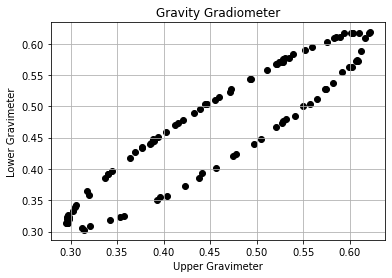

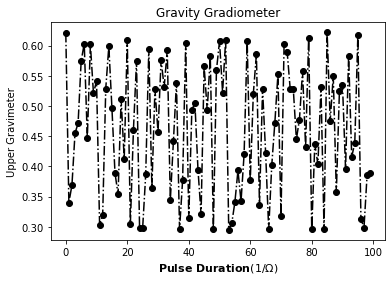

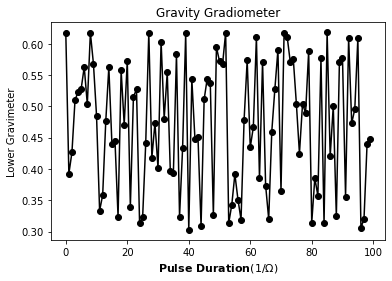

In [63]:
plt.figure()
plt.scatter(up[0:100],down[0:100],color = 'black')
plt.grid()
plt.ylabel('Lower Gravimeter')
plt.xlabel('Upper Gravimeter')
plt.title('Gravity Gradiometer')

plt.figure()
plt.plot(up[0:100],linestyle = '-.',color = 'black',marker = 'o',markerfacecolor = 'black')
plt.ylabel('Upper Gravimeter')
plt.title('Gravity Gradiometer')
plt.xlabel('Pulse Duration'+r'$(1/ \Omega)$', fontsize=11, fontweight='bold')

plt.figure()
plt.plot(down[0:100],linestyle = '-',color = 'black',marker = 'o',markerfacecolor = 'black')
plt.ylabel('Lower Gravimeter')
plt.xlabel('Pulse Duration'+r'$(1/ \Omega)$', fontsize=11, fontweight='bold')
plt.title('Gravity Gradiometer')

In [64]:
epoch = 0

for i in range(0,shotsPerEllipse*finalEllipse,shotsPerEllipse): 
    x = up[0+i:i+shotsPerEllipse]
    y = down[0+i:i+shotsPerEllipse]
    x = np.reshape(x,(len(x),1))
    y = np.reshape(y,(len(y),1))


    A =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    
    S = np.dot(A.T,A)

    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    S = S.astype(float)
    E, V =  eig(np.dot(inv(S), C))
    n = np.argmax(np.abs(E))
    coff = V[:,n]

    t = np.dot(A,coff)
    t1 = t
    Sk_1 = np.array([[1],[1]])

    df = pd.DataFrame()



    rw_maker = np.linspace(1,len(t),len(t)) 
    ti = np.tile(np.reshape(rw_maker,(len(t),1)), (1, len(t)))
    tj = np.tile(np.reshape(rw_maker,(1,len(t))), (len(t),1))
    Qrx = ti+tj - abs(ti-tj)
    Qry = ti+tj - abs(ti-tj)
    Qwx = np.eye(len(t))
    Qwy = np.eye(len(t))
    Qr = np.zeros((2*len(t),2*len(t)))
    Qr[0:len(t),0:len(t)] = Qrx/2
    Qr[len(t):,len(t):] = Qry/2
    Qw = np.zeros((2*len(t),2*len(t)))
    Qw[0:len(t),0:len(t)] = Qwx
    Qw[len(t):,len(t):] = Qwy



    while 1:
        A =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
        t = A@coff
        Bx = np.zeros((len(t),len(t)))
        By = np.zeros((len(t),len(t)))
        np.fill_diagonal(Bx, 2*coff[0]*x + coff[1]*y + coff[3])
        np.fill_diagonal(By, 2*coff[3]*y + coff[1]*x + coff[4])
        B = np.concatenate((Bx, By), axis=1)
        
        Qx = Sk_1[0]*Qw + Sk_1[1]*Qr
        Qt = np.dot(np.dot(B,Qx),B.T)

        Sk = Sk_1

        lw = 0.5*t.T@inv(Qt)@B@Qw@B.T@inv(Qt)@t
        lr = 0.5*t.T@inv(Qt)@B@Qr@B.T@inv(Qt)@t
        nwwl = 0.5*np.trace(B@Qw@B.T@inv(Qt)@B@Qw@B.T@inv(Qt))
        nrrl = 0.5*np.trace(B@Qr@B.T@inv(Qt)@B@Qr@B.T@inv(Qt))
        nrwl = 0.5*np.trace(B@Qr@B.T@inv(Qt)@B@Qw@B.T@inv(Qt))
        nwrl = 0.5*np.trace(B@Qw@B.T@inv(Qt)@B@Qr@B.T@inv(Qt))

        N = np.array([[nwwl,nwrl],[nrwl,nrrl]])
        l = np.array([[lw],[lr]])

        Sk_1 = inv(N)@l
        diff_Sk = Sk - Sk_1
        if diff_Sk.T@diff_Sk <10**(-4):
            A =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
            t = A@coff
            Bx = np.zeros((len(t),len(t)))
            By = np.zeros((len(t),len(t)))
            np.fill_diagonal(Bx, 2*coff[0]*x + coff[1]*y + coff[3])
            np.fill_diagonal(By, 2*coff[3]*y + coff[1]*x + coff[4])
            B = np.concatenate((Bx, By), axis=1)
            Qx = Sk_1[0]*Qw + Sk_1[1]*Qr
            Qt = np.dot(np.dot(B,Qx),B.T)
            coff = inv(A.T@inv(Qt)@A)@A.T@inv(Qt)@t

            break


    b = np.size(N, 0)
    L = -0.5*np.sum(log(np.abs(eigvals(Qt))))-0.5*(t.T@inv(Qt)@t) - b/2*log(2*np.pi)

    si = np.linspace(0, 2*np.pi, 100)

    P2,P3,P4,P5,P6,P1 = coff[1], coff[2], coff[3], coff[4], coff[5], coff[0] # P1x^2 + P2xy + P3y^2 + P4x + P5y + P6 = 0

    x_c = (P3*P4/2 - P2*P5/4)/(P2**2/4 - P1*P3)
    y_c = (P1*P5/2 - P2*P4/4)/(P2**2/4 - P1*P3)
    theta = 0.5*np.arctan(P2/(P1-P3))


    SemiMajor_Ax = np.sqrt(2*(P1*P5**2/4 + P3*P4**2/4 + P6*P2**2/4 - P2*P4*P5/4 -P1*P3*P6)/((P2**2/4 - P1*P3)*( (P3-P1)*np.sqrt(1+P2**2/(P1-P3)**2) - (P3+P1))))
    SemiMinor_Ax = np.sqrt(2*(P1*P5**2/4 + P3*P4**2/4 + P6*P2**2/4 - P2*P4*P5/4 -P1*P3*P6)/((P2**2/4 - P1*P3)*( (P1-P3)*np.sqrt(1+P2**2/(P1-P3)**2) - (P1+P3))))


    phase_gg = np.pi-np.arccos(-P2/(2*np.sqrt(P1*P3)))

        # Parametric equations for the rotated ellipse
    x_rotated = x_c + SemiMajor_Ax * np.cos(si) * np.cos(theta) - SemiMinor_Ax * np.sin(si) * np.sin(theta)
    y_rotated = y_c + SemiMajor_Ax * np.cos(si) * np.sin(theta) + SemiMinor_Ax * np.sin(si) * np.cos(theta)

    epoch = epoch+1
    # ['UpInterferometerData','DownInterferometerData','Epoch', 'A', 'B' , 'C' , 'D' , 'E' , 'F' , 'x_center' , 'y_center','Orientation','Phase','x_ellipse','y_ellipse','Sigma','SigmaVariance']
    infor = [{'UpInterferometerData':x,'DownInterferometerData':y,'Epoch':epoch,'A':coff[0],'B':coff[1],'C':coff[2],'D':coff[3],'E':coff[4],'F':coff[5],'x_center':x_c,'y_center':y_c,'Orientation':theta,'Phase':phase_gg,'x_ellipse':x_rotated,'y_ellipse':y_rotated,'Sigma':Sk_1,'SigmaVariance':inv(N),'MaxLikelihood':L,'Residual':t}]
    FitEllipseData_WhiteAndRandom = pd.concat([FitEllipseData_WhiteAndRandom, pd.DataFrame(infor, index=[0])], ignore_index=True)
    


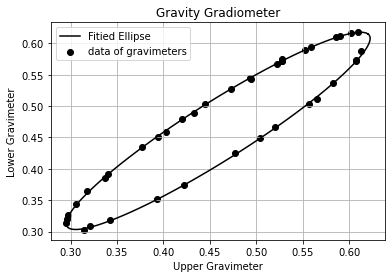

In [65]:
plt.figure()
plt.plot(FitEllipseData_WhiteAndRandom['x_ellipse'].iloc[1],FitEllipseData_WhiteAndRandom['y_ellipse'].iloc[1],color = 'black',label = 'Fitied Ellipse')
plt.scatter(FitEllipseData_WhiteAndRandom['UpInterferometerData'].iloc[1],FitEllipseData_WhiteAndRandom['DownInterferometerData'].iloc[1],color = 'black',label = 'data of gravimeters')
plt.grid()
plt.legend()
plt.ylabel('Lower Gravimeter')
plt.xlabel('Upper Gravimeter')
plt.title('Gravity Gradiometer')
plt.show()

In [66]:
epoch = 0

for i in range(0,shotsPerEllipse*finalEllipse,shotsPerEllipse): 
    x = up[0+i:i+shotsPerEllipse]
    y = down[0+i:i+shotsPerEllipse]
    x = np.reshape(x,(len(x),1))
    y = np.reshape(y,(len(y),1))


    A =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    
    S = np.dot(A.T,A)

    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    S = S.astype(float)
    E, V =  eig(np.dot(inv(S), C))
    n = np.argmax(np.abs(E))
    coff = V[:,n]

    t = np.dot(A,coff)
    t1 = t
    Sk_1 = np.array([[1],[1]])

    df = pd.DataFrame()



    m = len(t)  # Assuming m is some integer value

    t = np.arange(1, m+1)[:, np.newaxis]
    tau = np.abs(np.tile(t, (1, m)) - np.tile(t.T, (m, 1)))
    Qam = np.exp(-tau)
    Qwx = np.eye(len(t))
    Qwy = np.eye(len(t))
    Qatr = np.zeros((2*len(t),2*len(t)))
    Qatr[0:len(t),0:len(t)] = Qam
    Qatr[len(t):,len(t):] = Qam
    Qw = np.zeros((2*len(t),2*len(t)))
    Qw[0:len(t),0:len(t)] = Qwx
    Qw[len(t):,len(t):] = Qwy

  

    while 1:
        A =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
        t = A@coff
        Bx = np.zeros((len(t),len(t)))
        By = np.zeros((len(t),len(t)))
        np.fill_diagonal(Bx, 2*coff[0]*x + coff[1]*y + coff[3])
        np.fill_diagonal(By, 2*coff[3]*y + coff[1]*x + coff[4])
        B = np.concatenate((Bx, By), axis=1)
        
        Qx = Sk_1[0]*Qw + Sk_1[1]*Qatr
        Qt = np.dot(np.dot(B,Qx),B.T)

        coff = inv(A.T@inv(Qt)@A)@A.T@inv(Qt)@t
        
        Sk = Sk_1

        lw = 0.5*t.T@inv(Qt)@B@Qw@B.T@inv(Qt)@t
        la = 0.5*t.T@inv(Qt)@B@Qatr@B.T@inv(Qt)@t
        nwwl = 0.5*np.trace(B@Qw@B.T@inv(Qt)@B@Qw@B.T@inv(Qt))
        naal = 0.5*np.trace(B@Qatr@B.T@inv(Qt)@B@Qatr@B.T@inv(Qt))
        nawl = 0.5*np.trace(B@Qatr@B.T@inv(Qt)@B@Qw@B.T@inv(Qt))
        nwal = 0.5*np.trace(B@Qw@B.T@inv(Qt)@B@Qatr@B.T@inv(Qt))

        N = np.array([[nwwl,nawl],[nwal,naal]])
        l = np.array([[lw],[la]])

        Sk_1 = inv(N)@l
        diff_Sk = Sk - Sk_1
        if diff_Sk.T@diff_Sk <10**(-4):
            A =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
            t = A@coff
            Bx = np.zeros((len(t),len(t)))
            By = np.zeros((len(t),len(t)))
            np.fill_diagonal(Bx, 2*coff[0]*x + coff[1]*y + coff[3])
            np.fill_diagonal(By, 2*coff[3]*y + coff[1]*x + coff[4])
            B = np.concatenate((Bx, By), axis=1)
            Qx = Sk_1[0]*Qw + Sk_1[1]*Qatr
            Qt = np.dot(np.dot(B,Qx),B.T)
            coff = inv(A.T@inv(Qt)@A)@A.T@inv(Qt)@t

            break


    b = np.size(N, 0)
    L = -0.5*np.sum(log(np.abs(eigvals(Qt))))-0.5*(t.T@inv(Qt)@t) - b/2*log(2*np.pi)

    si = np.linspace(0, 2*np.pi, 100)

    P2,P3,P4,P5,P6,P1 = coff[1], coff[2], coff[3], coff[4], coff[5], coff[0] # P1x^2 + P2xy + P3y^2 + P4x + P5y + P6 = 0

    x_c = (P3*P4/2 - P2*P5/4)/(P2**2/4 - P1*P3)
    y_c = (P1*P5/2 - P2*P4/4)/(P2**2/4 - P1*P3)
    theta = 0.5*np.arctan(P2/(P1-P3))


    SemiMajor_Ax = np.sqrt(2*(P1*P5**2/4 + P3*P4**2/4 + P6*P2**2/4 - P2*P4*P5/4 -P1*P3*P6)/((P2**2/4 - P1*P3)*( (P3-P1)*np.sqrt(1+P2**2/(P1-P3)**2) - (P3+P1))))
    SemiMinor_Ax = np.sqrt(2*(P1*P5**2/4 + P3*P4**2/4 + P6*P2**2/4 - P2*P4*P5/4 -P1*P3*P6)/((P2**2/4 - P1*P3)*( (P1-P3)*np.sqrt(1+P2**2/(P1-P3)**2) - (P1+P3))))


    phase_gg = np.pi-np.arccos(-P2/(2*np.sqrt(P1*P3)))
    
        # Parametric equations for the rotated ellipse
    x_rotated = x_c + SemiMajor_Ax * np.cos(si) * np.cos(theta) - SemiMinor_Ax * np.sin(si) * np.sin(theta)
    y_rotated = y_c + SemiMajor_Ax * np.cos(si) * np.sin(theta) + SemiMinor_Ax * np.sin(si) * np.cos(theta)

    epoch = epoch+1
    # ['UpInterferometerData','DownInterferometerData','Epoch', 'A', 'B' , 'C' , 'D' , 'E' , 'F' , 'x_center' , 'y_center','Orientation','Phase','x_ellipse','y_ellipse','Sigma','SigmaVariance']
    infor = [{'UpInterferometerData':x,'DownInterferometerData':y,'Epoch':epoch,'A':coff[0],'B':coff[1],'C':coff[2],'D':coff[3],'E':coff[4],'F':coff[5],'x_center':x_c,'y_center':y_c,'Orientation':theta,'Phase':phase_gg,'x_ellipse':x_rotated,'y_ellipse':y_rotated,'Sigma':Sk_1,'SigmaVariance':inv(N),'MaxLikelihood':L,'Residual':t}]
    FitEllipseData_WhiteAndAutoRegressive = pd.concat([FitEllipseData_WhiteAndAutoRegressive, pd.DataFrame(infor, index=[0])], ignore_index=True)
    


In [67]:
epoch = 0

for i in range(0,shotsPerEllipse*finalEllipse,shotsPerEllipse): 
    x = up[0+i:i+shotsPerEllipse]
    y = down[0+i:i+shotsPerEllipse]
    x = np.reshape(x,(len(x),1))
    y = np.reshape(y,(len(y),1))


    A =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    
    S = np.dot(A.T,A)

    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    S = S.astype(float)
    E, V =  eig(np.dot(inv(S), C))
    n = np.argmax(np.abs(E))
    coff = V[:,n]

    t = np.dot(A,coff)
    t1 = t
    Sk_1 = np.array([[1],[1]])

    df = pd.DataFrame()



    m = len(t)  # Assuming m is some integer value

    t = np.arange(1, m+1)[:, np.newaxis]
    tau = np.abs(np.tile(t, (1, m)) - np.tile(t.T, (m, 1)))
    tau = tau + 0.25 * np.eye(m)
    Qfm = (1 - (((np.log(tau) / np.log(2)) + 2) / 24)) * (9 / 8)
    Qwx = np.eye(len(t))
    Qwy = np.eye(len(t))
    Qfn = np.zeros((2*len(t),2*len(t)))
    Qfn[0:len(t),0:len(t)] = Qfm
    Qfn[len(t):,len(t):] = Qfm
    Qw = np.zeros((2*len(t),2*len(t)))
    Qw[0:len(t),0:len(t)] = Qwx
    Qw[len(t):,len(t):] = Qwy

  

    while 1:
        A =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
        t = A@coff
        Bx = np.zeros((len(t),len(t)))
        By = np.zeros((len(t),len(t)))
        np.fill_diagonal(Bx, 2*coff[0]*x + coff[1]*y + coff[3])
        np.fill_diagonal(By, 2*coff[3]*y + coff[1]*x + coff[4])
        B = np.concatenate((Bx, By), axis=1)
        
        Qx = Sk_1[0]*Qw + Sk_1[1]*Qfn
        Qt = np.dot(np.dot(B,Qx),B.T)

        coff = inv(A.T@inv(Qt)@A)@A.T@inv(Qt)@t
        
        Sk = Sk_1

        lw = 0.5*t.T@inv(Qt)@B@Qw@B.T@inv(Qt)@t
        lf = 0.5*t.T@inv(Qt)@B@Qfn@B.T@inv(Qt)@t
        nwwl = 0.5*np.trace(B@Qw@B.T@inv(Qt)@B@Qw@B.T@inv(Qt))
        nffl = 0.5*np.trace(B@Qfn@B.T@inv(Qt)@B@Qfn@B.T@inv(Qt))
        nfwl = 0.5*np.trace(B@Qfn@B.T@inv(Qt)@B@Qw@B.T@inv(Qt))
        nwfl = 0.5*np.trace(B@Qw@B.T@inv(Qt)@B@Qfn@B.T@inv(Qt))

        N = np.array([[nwwl,nfwl],[nwfl,nffl]])
        l = np.array([[lw],[lf]])

        Sk_1 = inv(N)@l
        diff_Sk = Sk - Sk_1
        if diff_Sk.T@diff_Sk <10**(-4):
            A =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
            t = A@coff
            Bx = np.zeros((len(t),len(t)))
            By = np.zeros((len(t),len(t)))
            np.fill_diagonal(Bx, 2*coff[0]*x + coff[1]*y + coff[3])
            np.fill_diagonal(By, 2*coff[3]*y + coff[1]*x + coff[4])
            B = np.concatenate((Bx, By), axis=1)
            Qx = Sk_1[0]*Qw + Sk_1[1]*Qfn
            Qt = np.dot(np.dot(B,Qx),B.T)
            coff = inv(A.T@inv(Qt)@A)@A.T@inv(Qt)@t

            break


    b = np.size(N, 0)
    L = -0.5*np.sum(log(np.abs(eigvals(Qt))))-0.5*(t.T@inv(Qt)@t) - b/2*log(2*np.pi)

    si = np.linspace(0, 2*np.pi, 100)

    P2,P3,P4,P5,P6,P1 = coff[1], coff[2], coff[3], coff[4], coff[5], coff[0] # P1x^2 + P2xy + P3y^2 + P4x + P5y + P6 = 0

    x_c = (P3*P4/2 - P2*P5/4)/(P2**2/4 - P1*P3)
    y_c = (P1*P5/2 - P2*P4/4)/(P2**2/4 - P1*P3)
    theta = 0.5*np.arctan(P2/(P1-P3))


    SemiMajor_Ax = np.sqrt(2*(P1*P5**2/4 + P3*P4**2/4 + P6*P2**2/4 - P2*P4*P5/4 -P1*P3*P6)/((P2**2/4 - P1*P3)*( (P3-P1)*np.sqrt(1+P2**2/(P1-P3)**2) - (P3+P1))))
    SemiMinor_Ax = np.sqrt(2*(P1*P5**2/4 + P3*P4**2/4 + P6*P2**2/4 - P2*P4*P5/4 -P1*P3*P6)/((P2**2/4 - P1*P3)*( (P1-P3)*np.sqrt(1+P2**2/(P1-P3)**2) - (P1+P3))))


    phase_gg = np.pi-np.arccos(-P2/(2*np.sqrt(P1*P3)))

        # Parametric equations for the rotated ellipse
    x_rotated = x_c + SemiMajor_Ax * np.cos(si) * np.cos(theta) - SemiMinor_Ax * np.sin(si) * np.sin(theta)
    y_rotated = y_c + SemiMajor_Ax * np.cos(si) * np.sin(theta) + SemiMinor_Ax * np.sin(si) * np.cos(theta)

    epoch = epoch+1
    
    # ['UpInterferometerData','DownInterferometerData','Epoch', 'A', 'B' , 'C' , 'D' , 'E' , 'F' , 'x_center' , 'y_center','Orientation','Phase','x_ellipse','y_ellipse','Sigma','SigmaVariance']
    infor = [{'UpInterferometerData':x,'DownInterferometerData':y,'Epoch':epoch,'A':coff[0],'B':coff[1],'C':coff[2],'D':coff[3],'E':coff[4],'F':coff[5],'x_center':x_c,'y_center':y_c,'Orientation':theta,'Phase':phase_gg,'x_ellipse':x_rotated,'y_ellipse':y_rotated,'Sigma':Sk_1,'SigmaVariance':inv(N),'MaxLikelihood':L,'Residual':t}]
    FitEllipseData_WhiteAndFliker = pd.concat([FitEllipseData_WhiteAndFliker, pd.DataFrame(infor, index=[0])], ignore_index=True)
    


In [68]:
epoch = 0

for i in range(0,shotsPerEllipse*finalEllipse,shotsPerEllipse): 
    x = up[0+i:i+shotsPerEllipse]
    y = down[0+i:i+shotsPerEllipse]
    x = np.reshape(x,(len(x),1))
    y = np.reshape(y,(len(y),1))


    A =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    
    S = np.dot(A.T,A)

    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    S = S.astype(float)
    E, V =  eig(np.dot(inv(S), C))
    n = np.argmax(np.abs(E))
    coff = V[:,n]

    t = np.dot(A,coff)
    t1 = t
    Sk_1 = np.array([[1]])

    df = pd.DataFrame()



    m = len(t)  # Assuming m is some integer value


    Qwx = np.eye(len(t))
    Qwy = np.eye(len(t))
    Qw = np.zeros((2*len(t),2*len(t)))
    Qw[0:len(t),0:len(t)] = Qwx
    Qw[len(t):,len(t):] = Qwy

  

    while 1:
        A =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
        t = A@coff
        Bx = np.zeros((len(t),len(t)))
        By = np.zeros((len(t),len(t)))
        np.fill_diagonal(Bx, 2*coff[0]*x + coff[1]*y + coff[3])
        np.fill_diagonal(By, 2*coff[3]*y + coff[1]*x + coff[4])
        B = np.concatenate((Bx, By), axis=1)
        
        Qx = Sk_1[0]*Qw 
        Qt = np.dot(np.dot(B,Qx),B.T)

        coff = inv(A.T@inv(Qt)@A)@A.T@inv(Qt)@t
        
        Sk = Sk_1

        lw = 0.5*t.T@inv(Qt)@B@Qw@B.T@inv(Qt)@t
 
        nwwl = 0.5*np.trace(B@Qw@B.T@inv(Qt)@B@Qw@B.T@inv(Qt))


        N = np.array([[nwwl]])
        l = np.array([[lw]])

        Sk_1 = inv(N)@l
        diff_Sk = Sk - Sk_1
        if diff_Sk.T@diff_Sk <10**(-4):
            A =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
            t = A@coff
            Bx = np.zeros((len(t),len(t)))
            By = np.zeros((len(t),len(t)))
            np.fill_diagonal(Bx, 2*coff[0]*x + coff[1]*y + coff[3])
            np.fill_diagonal(By, 2*coff[3]*y + coff[1]*x + coff[4])
            B = np.concatenate((Bx, By), axis=1)
            Qx = Sk_1[0]*Qw
            Qt = np.dot(np.dot(B,Qx),B.T)
            coff = inv(A.T@inv(Qt)@A)@A.T@inv(Qt)@t

            break


    b = np.size(N, 0)
    L = -0.5*np.sum(log(np.abs(eigvals(Qt))))-0.5*(t.T@inv(Qt)@t) - b/2*log(2*np.pi)

    si = np.linspace(0, 2*np.pi, 100)

    P2,P3,P4,P5,P6,P1 = coff[1], coff[2], coff[3], coff[4], coff[5], coff[0] # P1x^2 + P2xy + P3y^2 + P4x + P5y + P6 = 0

    x_c = (P3*P4/2 - P2*P5/4)/(P2**2/4 - P1*P3)
    y_c = (P1*P5/2 - P2*P4/4)/(P2**2/4 - P1*P3)
    theta = 0.5*np.arctan(P2/(P1-P3))


    SemiMajor_Ax = np.sqrt(2*(P1*P5**2/4 + P3*P4**2/4 + P6*P2**2/4 - P2*P4*P5/4 -P1*P3*P6)/((P2**2/4 - P1*P3)*( (P3-P1)*np.sqrt(1+P2**2/(P1-P3)**2) - (P3+P1))))
    SemiMinor_Ax = np.sqrt(2*(P1*P5**2/4 + P3*P4**2/4 + P6*P2**2/4 - P2*P4*P5/4 -P1*P3*P6)/((P2**2/4 - P1*P3)*( (P1-P3)*np.sqrt(1+P2**2/(P1-P3)**2) - (P1+P3))))


    phase_gg = np.pi-np.arccos(-P2/(2*np.sqrt(P1*P3)))

        # Parametric equations for the rotated ellipse
    x_rotated = x_c + SemiMajor_Ax * np.cos(si) * np.cos(theta) - SemiMinor_Ax * np.sin(si) * np.sin(theta)
    y_rotated = y_c + SemiMajor_Ax * np.cos(si) * np.sin(theta) + SemiMinor_Ax * np.sin(si) * np.cos(theta)

    epoch = epoch+1
    # ['UpInterferometerData','DownInterferometerData','Epoch', 'A', 'B' , 'C' , 'D' , 'E' , 'F' , 'x_center' , 'y_center','Orientation','Phase','x_ellipse','y_ellipse','Sigma','SigmaVariance']
    infor = [{'UpInterferometerData':x,'DownInterferometerData':y,'Epoch':epoch,'A':coff[0],'B':coff[1],'C':coff[2],'D':coff[3],'E':coff[4],'F':coff[5],'x_center':x_c,'y_center':y_c,'Orientation':theta,'Phase':phase_gg,'x_ellipse':x_rotated,'y_ellipse':y_rotated,'Sigma':Sk_1,'SigmaVariance':inv(N),'MaxLikelihood':L,'Residual':t}]
    FitEllipseData_White = pd.concat([FitEllipseData_White, pd.DataFrame(infor, index=[0])], ignore_index=True)
    


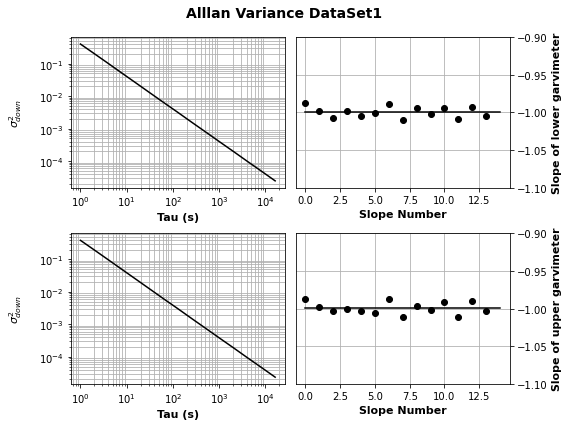

In [69]:
# %matplotlib qt  
taus , adevs, errors, ns = allantools.oadev(data[:,0])
adevs = adevs*2
plt.figure(figsize=(8, 6))
plt.subplot(2,2,1)
plt.loglog(taus,adevs,color = 'black')
plt.xlabel('Tau (s)', fontsize=11, fontweight='bold')
plt.ylabel(r'$\sigma^2_{down}$', labelpad=15, fontsize=11, fontweight='bold')
plt.grid('True',which='minor')

d = np.zeros((len(taus)-1,1))
for i in range(0,len(taus)-1):
    d[i,0] = (np.log(adevs[i+1])-np.log(adevs[i]))/(np.log(taus[i+1])-np.log(taus[i]))
    

plt.subplot(2,2,2)
plt.plot(d,'o',color = 'black')
plt.plot(np.linspace(0,len(d),len(d)),np.mean(d)*np.ones((len(d),1)),color = 'black')
plt.xlabel('Slope Number', fontsize=11, fontweight='bold')
plt.ylabel('Slope of lower garvimeter', fontsize=11, fontweight='bold')
plt.ylim([-1-0.1,-1+0.1])
plt.grid()
plt.gca().yaxis.set_ticks_position('right')
plt.gca().yaxis.set_label_position('right')
# plt.gca().spines['left'].set_visible(False)

taus , adevs, errors, ns = allantools.oadev(data[:,1])
adevs = adevs*2
plt.subplot(223)
plt.loglog(taus,adevs,color = 'black')
plt.xlabel('Tau (s)', fontsize=11, fontweight='bold')
plt.ylabel(r'$\sigma^2_{down}$', labelpad=15, fontsize=11, fontweight='bold')
plt.grid('True',which='minor')

d = np.zeros((len(taus)-1,1))
for i in range(0,len(taus)-1):
    d[i,0] = (np.log(adevs[i+1])-np.log(adevs[i]))/(np.log(taus[i+1])-np.log(taus[i]))
    

plt.subplot(2,2,4)
plt.plot(d,'o',color = 'black')
plt.plot(np.linspace(0,len(d),len(d)),np.mean(d)*np.ones((len(d),1)),color = 'black')
plt.xlabel('Slope Number', fontsize=11, fontweight='bold')
plt.ylabel('Slope of upper garvimeter', fontsize=11, fontweight='bold')
plt.ylim([-1-0.1,-1+0.1])
plt.grid()
plt.gca().yaxis.set_ticks_position('right')
plt.gca().yaxis.set_label_position('right')
# plt.gca().spines['left'].set_visible(False)


plt.suptitle('Alllan Variance DataSet1', fontsize=14, fontweight='bold')
plt.tight_layout()

plt.savefig('FigOutPut/figure5.png', dpi=800)


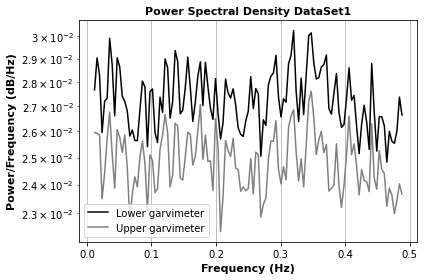

In [70]:
frequencies, psd = welch(data[:,0])

# Plot the power spectral density
plt.figure(figsize=(6, 4))
plt.semilogy(frequencies[3:len(psd)-3], psd[3:len(psd)-3], label = 'Lower garvimeter',color = 'black')
plt.xlabel('Frequency (Hz)', fontsize=11, fontweight='bold')
plt.ylabel('Power/Frequency (dB/Hz)', fontsize=11, fontweight='bold')
plt.title('Power Spectral Density DataSet1', fontsize=11, fontweight='bold')
plt.grid(True)

frequencies, psd = welch(data[:,1])
plt.semilogy(frequencies[3:len(psd)-3], psd[3:len(psd)-3],label = 'Upper garvimeter',color = 'gray')
plt.legend()
plt.tight_layout()

plt.savefig('FigOutPut/figure7.png', dpi=400)


In [71]:
FitEllipseData_WhiteAndRandom['MaxLikelihood']

0        357.02777
1       366.131245
2       362.599778
3       366.930892
4       368.653011
           ...    
1457     357.64036
1458    358.072001
1459    369.342404
1460    369.561644
1461    361.662205
Name: MaxLikelihood, Length: 1462, dtype: object

In [72]:
FitEllipseData_White['MaxLikelihood']

0       359.493719
1       367.832514
2         364.0826
3          368.772
4       369.955747
           ...    
1457    359.133744
1458    357.848194
1459    370.367943
1460    369.047637
1461    362.660265
Name: MaxLikelihood, Length: 1462, dtype: object

In [73]:
FitEllipseData_WhiteAndFliker['MaxLikelihood']

0       358.068545
1       367.000993
2       362.552332
3       367.001811
4       369.954275
           ...    
1457    357.482314
1458    357.071007
1459    368.764318
1460    367.520376
1461    363.384833
Name: MaxLikelihood, Length: 1462, dtype: object

In [74]:
FitEllipseData_WhiteAndAutoRegressive['MaxLikelihood']

0       359.082216
1       367.113332
2        364.07165
3       368.313842
4       369.043554
           ...    
1457    358.593434
1458    357.028794
1459    370.211044
1460    369.022169
1461    361.755869
Name: MaxLikelihood, Length: 1462, dtype: object

In [75]:
MaxLikelihood = np.array([[FitEllipseData_White['MaxLikelihood'].mean()],[FitEllipseData_WhiteAndRandom['MaxLikelihood'].mean()]
                          ,[FitEllipseData_WhiteAndFliker['MaxLikelihood'].mean()],[FitEllipseData_WhiteAndAutoRegressive['MaxLikelihood'].mean()]])
np.savetxt('DataOutPut/Dataset1_Maximumliklehood.txt', MaxLikelihood)

In [76]:
resd = np.stack(FitEllipseData_White['Residual'])
m,n = np.shape(resd)
resd = np.reshape(resd,(m*n,1))
np.savetxt('DataOutPut/resd1.txt', resd)


In [77]:
SigmaWhite = np.stack(FitEllipseData_White['Sigma'])
meanSigmaWhite = SigmaWhite.mean()
print(meanSigmaWhite)

SigmaVarianceWhite = np.stack(FitEllipseData_White['SigmaVariance'])
meanSigmaVarianceWhite = SigmaVarianceWhite.mean()/100
print(meanSigmaVarianceWhite)

2.97491824808417e-08
5.335432686236883e-19


In [78]:
SigmaWhiteAndRandom = np.stack(FitEllipseData_WhiteAndRandom['Sigma'])
m,n,p = np.shape(SigmaWhiteAndRandom)
SigmaWhiteAndRandom = SigmaWhiteAndRandom.reshape(m, 2)
meanSigmaWhiteAndRandom_white = SigmaWhiteAndRandom[:,0].mean()
meanSigmaWhiteAndRandom_Random = SigmaWhiteAndRandom[:,1].mean()
print(meanSigmaWhiteAndRandom_white,meanSigmaWhiteAndRandom_Random)

SigmaVarianceWhiteAndRandom = np.stack(FitEllipseData_WhiteAndRandom['SigmaVariance'])
m,n,p = np.shape(SigmaVarianceWhiteAndRandom)
SigmaVarianceWhiteAndRandom = SigmaVarianceWhiteAndRandom.reshape(m, 4)
meanSigmaVarianceWhiteAndRandom_white = SigmaVarianceWhiteAndRandom[:,0].mean()/100
meanSigmaVarianceWhiteAndRandom_Random = SigmaVarianceWhiteAndRandom[:,3].mean()/10000
print(meanSigmaVarianceWhiteAndRandom_white,meanSigmaVarianceWhiteAndRandom_Random)


2.921809999980031e-08 1.6385555561457195e-10
6.774905610476201e-19 6.039862493301603e-22


In [79]:
SigmaWhiteAndFliker = np.stack(FitEllipseData_WhiteAndFliker['Sigma'])
m,n,p = np.shape(SigmaWhiteAndFliker)
SigmaWhiteAndFliker = SigmaWhiteAndFliker.reshape(m, 2)
meanSigmaWhiteAndFliker_white = SigmaWhiteAndFliker[:,0].mean()
meanSigmaWhiteAndFliker_Fliker = SigmaWhiteAndFliker[:,1].mean()
print(meanSigmaWhiteAndFliker_white,meanSigmaWhiteAndFliker_Fliker)

SigmaVarianceWhiteAndFliker = np.stack(FitEllipseData_WhiteAndFliker['SigmaVariance'])
m,n,p = np.shape(SigmaVarianceWhiteAndFliker)
SigmaVarianceWhiteAndFliker = SigmaVarianceWhiteAndFliker.reshape(m, 4)
meanSigmaVarianceWhiteAndFliker_white = SigmaVarianceWhiteAndFliker[:,0].mean()/100
meanSigmaVarianceWhiteAndFliker_Fliker = SigmaVarianceWhiteAndFliker[:,3].mean()/10000
print(meanSigmaVarianceWhiteAndFliker_white,meanSigmaVarianceWhiteAndFliker_Fliker)

2.990116054247822e-08 -1.3403525256118896e-10
6.572411275874969e-19 1.2466664495070626e-20


In [80]:
SigmaWhiteAndAutoRegressive = np.stack(FitEllipseData_WhiteAndAutoRegressive['Sigma'])
m,n,p = np.shape(SigmaWhiteAndAutoRegressive)
SigmaWhiteAndAutoRegressive = SigmaWhiteAndAutoRegressive.reshape(m, 2)
meanSigmaWhiteAndAutoRegressive_white = SigmaWhiteAndAutoRegressive[:,0].mean()
meanSigmaWhiteAndAutoRegressive_AutoRegressive = SigmaWhiteAndAutoRegressive[:,1].mean()
print(meanSigmaWhiteAndAutoRegressive_white,meanSigmaWhiteAndAutoRegressive_AutoRegressive)

SigmaVarianceWhiteAndAutoRegressive = np.stack(FitEllipseData_WhiteAndAutoRegressive['SigmaVariance'])
m,n,p = np.shape(SigmaVarianceWhiteAndAutoRegressive)
SigmaVarianceWhiteAndAutoRegressive = SigmaVarianceWhiteAndAutoRegressive.reshape(m, 4)
meanSigmaVarianceWhiteAndFliker_white = SigmaVarianceWhiteAndAutoRegressive[:,0].mean()/100
meanSigmaVarianceWhiteAndFliker_AutoRegressive = SigmaVarianceWhiteAndAutoRegressive[:,3].mean()/10000
print(meanSigmaVarianceWhiteAndFliker_white,meanSigmaVarianceWhiteAndFliker_AutoRegressive)

3.134347738692438e-08 -1.3966127491688936e-09
2.2564551030965305e-18 1.739833698236144e-20
